In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
import random
import cv2
from sklearn.metrics import classification_report

from finetuning_functions import training_plots, dice_coefficient, Unet, plot_validation_masks

2023-10-23 15:08:50.111516: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-23 15:08:50.148404: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-23 15:08:50.148431: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-23 15:08:50.148458: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-23 15:08:50.155449: I tensorflow/core/platform/cpu_feature_g

# Data Loading

In [2]:
labeled_data_dir = os.path.join("..", "..", "..", "media", "FS2", "data", "updated_masks")

In [3]:
masked_images = [0 for i in range(150)]
smoke_masks = [0 for i in range(150)] 
cloud_masks =[0 for i in range(150)]
image_nos = []
for subdir, dirs, files in os.walk(labeled_data_dir):
    for file in files:
        file_path = os.path.join(labeled_data_dir, file)
        mask = np.load(os.path.join(labeled_data_dir, file))
        image_no = int(file.split("-")[1])-1
        image_nos.append(image_no)
        if "Smoke" in file_path and not "cloud" in file:
            smoke_masks[image_no] = mask
        if "cloud" in file:
            cloud_masks[image_no] = mask

In [4]:
for i in range(len(smoke_masks)):
    if np.shape(cloud_masks[i]) == ():
        blank_img = np.zeros(smoke_masks[i].shape,dtype=np.uint8)
        cloud_masks[i] = blank_img
    if np.shape(smoke_masks[i]) == ():
        blank_img = np.zeros(cloud_masks[i].shape,dtype=np.uint8)
        smoke_masks[i] = blank_img

In [5]:
(len(smoke_masks), len(cloud_masks))

(130, 130)

In [6]:
def combine_masks(smoke_masks, cloud_masks):
    masks = [0 for i in range(len(smoke_masks))]
    for i in range(len(smoke_masks)):
        smoke = smoke_masks[i]
        smoke = np.where(smoke==0, smoke, 1)
        temp = cloud_masks[i]
        temp = np.where(cloud_masks[i]!=255, cloud_masks[i], 2) #changing color to grey
        temp = np.where(cloud_masks[i]==0, temp, 2)
        full_mask = temp + smoke
        full_mask = np.where(full_mask!=3, full_mask, 1 )
        masks[i] = full_mask
    return masks

In [7]:
masked_images = combine_masks(smoke_masks, cloud_masks)

In [8]:
import re
numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [9]:
originals = []
original_image_dir = os.path.join("..", "..", "..", "media", "FS2", "data", "updated_images")
for subdir, dirs, files in os.walk(original_image_dir):
    for file in sorted(files, key=numericalSort):
        image = Image.open(os.path.join(original_image_dir, file)).convert('RGB')
        np_original = np.asarray(image)
        originals.append(np_original)
originals = originals[:150]
len(originals)

130

In [10]:
random.seed(42)
val_inds = random.sample([i for i in range(150)], 25)

In [11]:
class DataLoader:
    def __init__(self, masks, originals, target_shape=(256, 256)):
        self.masks = masks
        self.originals = originals
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.target_shape = target_shape
        
    @tf.function
    def parse_images(self, ind):
        mask = cv2.resize(np.expand_dims(self.masks[ind], axis=-1), self.target_shape)
        image = cv2.resize(self.originals[ind], self.target_shape)
        return image, mask
    
    @tf.function
    def data_generator(self, batch_size=4):
        random.seed(0)
        inds = random.sample([i for i in range(len(self.originals))], batch_size)
        inputs = [self.parse_images(ind)[0] for ind in inds]
        targets = [self.parse_images(ind)[1] for ind in inds]
        return inputs, targets

    def data_processor(self):
        inputs = [ cv2.resize(self.originals[ind], self.target_shape) for ind in range(len(self.originals))]
        return inputs


In [12]:
input_size = (512,512)
batch_size = 16
val_batch_size = 16

In [13]:
test_dataset = DataLoader(masked_images, originals, target_shape=input_size)
inputs, targets = test_dataset.data_generator(150)

2023-10-23 15:08:53.599118: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14636 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:d5:00.0, compute capability: 7.5


In [14]:
test_input = [inputs[ind] for ind in val_inds]
test_target = [targets[ind] for ind in val_inds]
val = tf.data.Dataset.from_tensor_slices((test_input, test_target))

# Data Augmentation

In [ ]:
def make_augmentations(inputs, targets):
    # augmentation - flip hz, flip vt, hz+vt flip, rotation 90, 180, 270

    augmented_inputs = []
    augmented_labels = []

    # flip hz
    hz_inputs = [np.flip(img, axis=1) for img in inputs]
    hz_labels =  [np.flip(img, axis=1) for img in targets]
    augmented_inputs = hz_inputs
    augmented_labels = hz_labels

    # flip vt
    vt_inputs = [np.flip(img, axis=0) for img in inputs]
    vt_labels =  [np.flip(img, axis=0) for img in targets]
    augmented_inputs = np.append(vt_inputs, augmented_inputs, axis=0)
    augmented_labels = np.append(vt_labels, augmented_labels, axis=0)

    # hz+vt flip
    hzvt_inputs = [np.flip(img, axis=0) for img in hz_inputs]
    hzvt_labels =  [np.flip(img, axis=0) for img in hz_labels]
    augmented_inputs = np.append(hzvt_inputs, augmented_inputs, axis=0)
    augmented_labels = np.append(hzvt_labels, augmented_labels, axis=0)

    # add to originals
    augmented_inputs = np.append(inputs, augmented_inputs, axis=0)
    augmented_labels = np.append(targets, augmented_labels, axis=0)

    # rotations 
    rot90_inputs = [np.flip(img, axis=0) for img in augmented_inputs]
    rot90_labels =  [np.flip(img, axis=0) for img in augmented_labels]
    rot180_inputs = [np.flip(img, axis=0) for img in rot90_inputs]
    rot180_labels =  [np.flip(img, axis=0) for img in rot90_labels]
    rot270_inputs = [np.flip(img, axis=0) for img in rot180_inputs]
    rot270_labels =  [np.flip(img, axis=0) for img in rot180_labels]

    rotation_inputs = rot90_inputs + rot180_inputs + rot270_inputs
    rotation_labels = rot90_labels + rot180_labels + rot270_labels 

    # add rotations
    augmented_inputs = np.append(rotation_inputs, augmented_inputs, axis=0)
    augmented_labels = np.append(rotation_labels, augmented_labels, axis=0)
    return  augmented_inputs, augmented_labels


In [15]:
inputs = [inputs[ind] for ind in range(150) if ind not in val_inds]
targets = [targets[ind] for ind in range(150) if ind not in val_inds]

In [17]:
train = tf.data.Dataset.from_tensor_slices((inputs, targets))
augmented_inputs, augmented_labels = make_augmentations(inputs, targets)
train_augmented = tf.data.Dataset.from_tensor_slices((augmented_inputs, augmented_labels))

In [18]:
train_batches = train.batch(batch_size)
train_augmented_batches = train_augmented.batch(batch_size)
val_batches = val.batch(val_batch_size)

# Training Set up

In [19]:
# Callbacks
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
model_ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    "models/smoke_segmentation_256.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=10e-8,
)

In [20]:
# training parameters
epochs =500
lr = 0.00001

# Unet

In [21]:
input = tf.keras.layers.Input(shape=(input_size[0], input_size[1], 3))
unet = Unet(input, dropout= 0.07)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 16)         0         ['batch_normalization[0][0

In [22]:
unet.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
    metrics=["accuracy", 
             tf.keras.metrics.MeanIoU(num_classes=3, sparse_y_true=True, sparse_y_pred=False)]
            )

In [23]:
history = unet.fit(
    train_batches,
    validation_data=val_batches,
    batch_size=batch_size,
    epochs=epochs, 
    callbacks=[
        early_stop_cb, 
        model_ckpt_cb, 
        reduce_lr_cb
    ])

Epoch 1/500


2023-10-23 15:09:05.643308: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-23 15:09:06.419964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-23 15:09:10.531211: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbe6c29cad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-23 15:09:10.531272: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-10-23 15:09:10.545325: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-23 15:09:10.694749: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster 

7/7 [==============================] - 29s 2s/step - loss: 1.3080 - accuracy: 0.3130 - mean_io_u: 0.1523 - val_loss: 4.0431 - val_accuracy: 0.5277 - val_mean_io_u: 0.1772 - lr: 1.0000e-05
Epoch 2/500


/home/sandrade/miniconda3/envs/odin/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 4s 631ms/step - loss: 1.2887 - accuracy: 0.3224 - mean_io_u: 0.1578 - val_loss: 2.9548 - val_accuracy: 0.4868 - val_mean_io_u: 0.1640 - lr: 1.0000e-05
Epoch 3/500
7/7 [==============================] - 4s 628ms/step - loss: 1.2696 - accuracy: 0.3320 - mean_io_u: 0.1634 - val_loss: 2.4787 - val_accuracy: 0.4227 - val_mean_io_u: 0.1436 - lr: 1.0000e-05
Epoch 4/500
7/7 [==============================] - 4s 632ms/step - loss: 1.2507 - accuracy: 0.3419 - mean_io_u: 0.1693 - val_loss: 2.1888 - val_accuracy: 0.3739 - val_mean_io_u: 0.1295 - lr: 1.0000e-05
Epoch 5/500
7/7 [==============================] - 4s 632ms/step - loss: 1.2318 - accuracy: 0.3522 - mean_io_u: 0.1755 - val_loss: 1.9836 - val_accuracy: 0.3398 - val_mean_io_u: 0.1221 - lr: 1.0000e-05
Epoch 6/500
7/7 [==============================] - 4s 628ms/step - loss: 1.2131 - accuracy: 0.3628 - mean_io_u: 0.1820 - val_loss: 1.8246 - val_accuracy: 0.3236 - val_mean_io_u: 0.1219 - lr: 1.0000e-05
Ep

In [24]:
unet_augmented = Unet(input, dropout= 0.07)
unet_augmented.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
    metrics=["accuracy", 
             tf.keras.metrics.MeanIoU(num_classes=3, sparse_y_true=True, sparse_y_pred=False)]
            )

In [25]:
history_augmented = unet_augmented.fit(
    train_augmented_batches,
    validation_data=val_batches,
    batch_size=batch_size,
    epochs=epochs, 
    callbacks=[
        early_stop_cb, 
        model_ckpt_cb, 
        reduce_lr_cb
    ])

Epoch 1/500


2023-10-23 15:16:01.209472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


105/105 [==============================] - 72s 609ms/step - loss: 1.7455 - accuracy: 0.1698 - mean_io_u_1: 0.0859 - val_loss: 2.2070 - val_accuracy: 0.2056 - val_mean_io_u_1: 0.0868 - lr: 1.0000e-05
Epoch 2/500
105/105 [==============================] - 63s 604ms/step - loss: 1.4960 - accuracy: 0.2284 - mean_io_u_1: 0.1191 - val_loss: 1.4306 - val_accuracy: 0.2660 - val_mean_io_u_1: 0.1315 - lr: 1.0000e-05
Epoch 3/500
105/105 [==============================] - 63s 604ms/step - loss: 1.2783 - accuracy: 0.2879 - mean_io_u_1: 0.1589 - val_loss: 1.2802 - val_accuracy: 0.3555 - val_mean_io_u_1: 0.1992 - lr: 1.0000e-05
Epoch 4/500
105/105 [==============================] - 64s 605ms/step - loss: 1.1106 - accuracy: 0.3865 - mean_io_u_1: 0.2266 - val_loss: 1.0270 - val_accuracy: 0.5255 - val_mean_io_u_1: 0.3421 - lr: 1.0000e-05
Epoch 5/500
105/105 [==============================] - 64s 605ms/step - loss: 0.9921 - accuracy: 0.4827 - mean_io_u_1: 0.2999 - val_loss: 0.8844 - val_accuracy: 0.6306 

# Evaluation

Regular vs Augmented

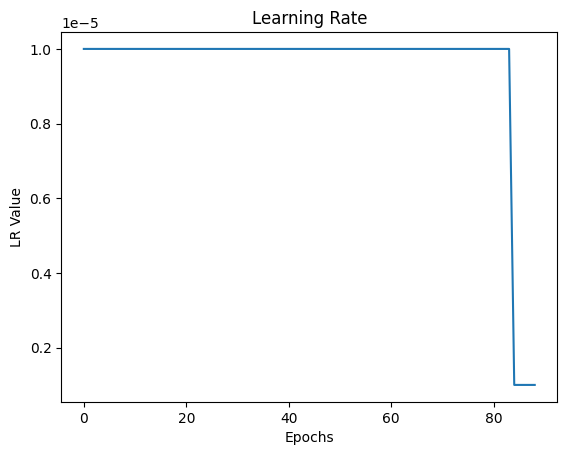

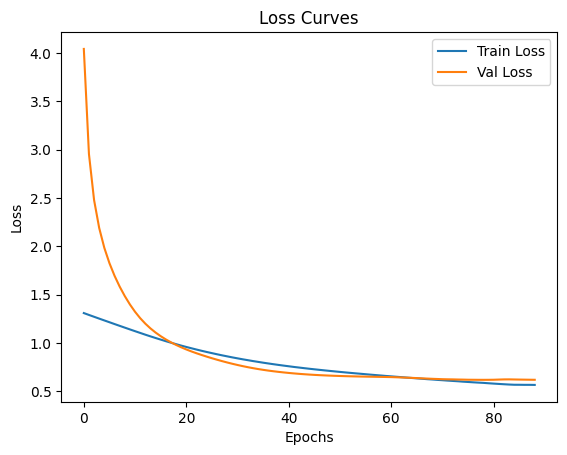

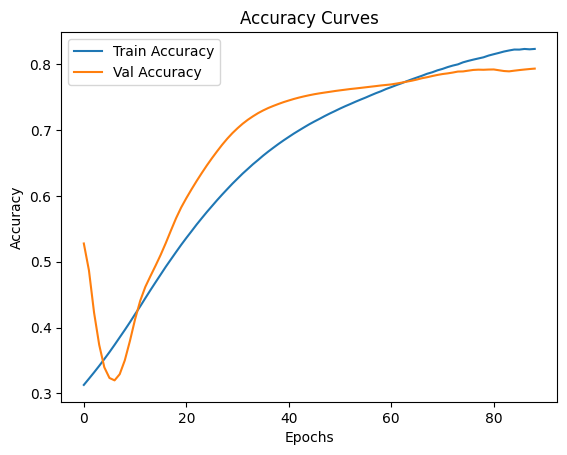

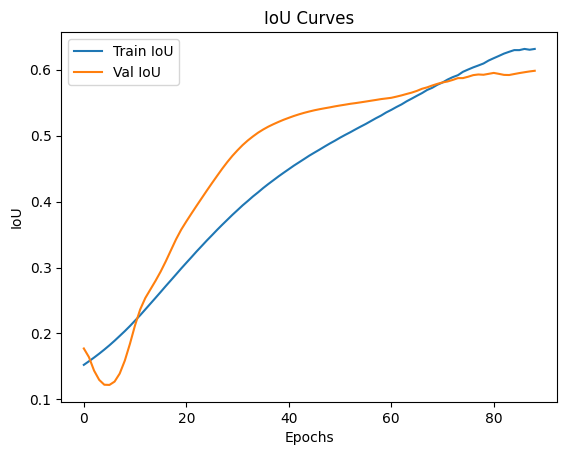

In [26]:
training_plots(history)

In [27]:
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

In [28]:
train_images, train_labels = tuple(zip(*train))
preds = unet.predict(train_batches)
print(classification_report(np.array(train_labels).flatten(), np.array(tf.argmax(preds, axis=-1)).flatten()))

7/7 [==============================] - 1s 110ms/step
              precision    recall  f1-score   support

           0       0.92      0.85      0.88  16916389
           1       0.52      0.81      0.63   5165033
           2       0.77      0.55      0.64   5443698

    accuracy                           0.78  27525120
   macro avg       0.73      0.73      0.72  27525120
weighted avg       0.81      0.78      0.79  27525120



In [55]:
m = tf.keras.metrics.MeanIoU(num_classes=3)
m.update_state(train_labels, tf.argmax(preds, axis=-1))
regular_iou = m.result().numpy()

In [56]:
images, labels = tuple(zip(*val))
preds = unet.predict(val_batches)
pred_mask = tf.argmax(preds, axis=-1) 

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 117ms/step


In [57]:
regular_metrics = classification_report(np.array(labels).flatten(), np.array(pred_mask).flatten(), output_dict=True)

In [ ]:
print(classification_report(np.array(labels).flatten(), np.array(pred_mask).flatten()))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90   3642002
           1       0.60      0.73      0.66   1405225
           2       0.78      0.54      0.64   1506373

    accuracy                           0.79   6553600
   macro avg       0.75      0.73      0.73   6553600
weighted avg       0.80      0.79      0.79   6553600



In [58]:
m.reset_state()
m.update_state(labels, pred_mask)
m.result().numpy()
regular_iou = m.result().numpy()

In [35]:
#plot_validation_masks(images, pred_mask, labels)

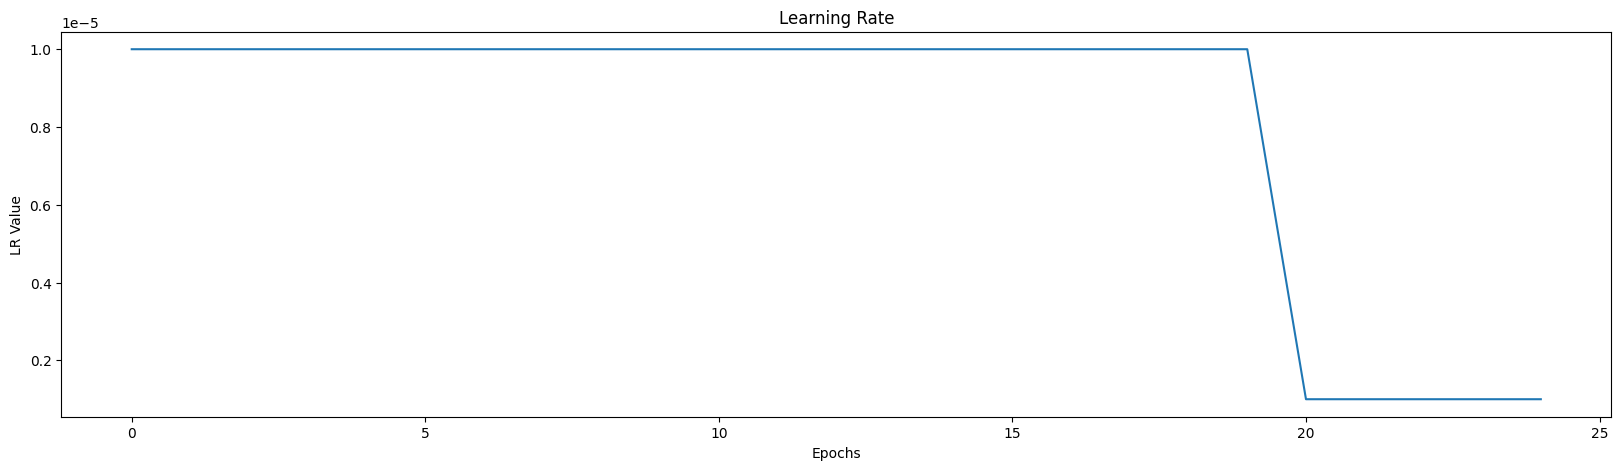

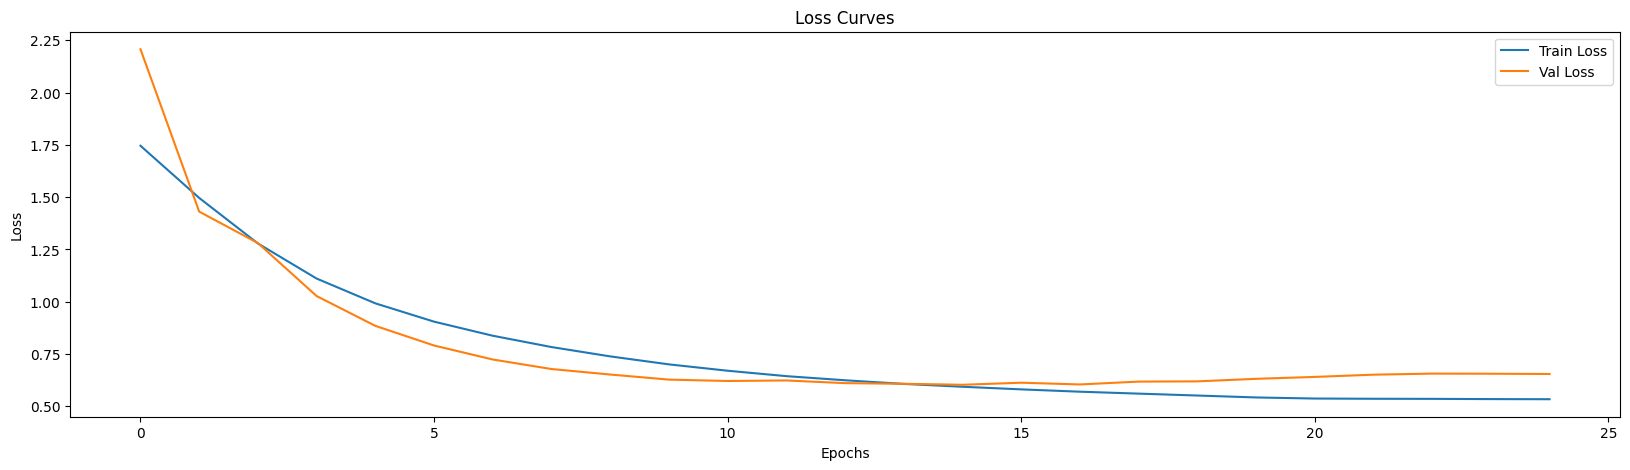

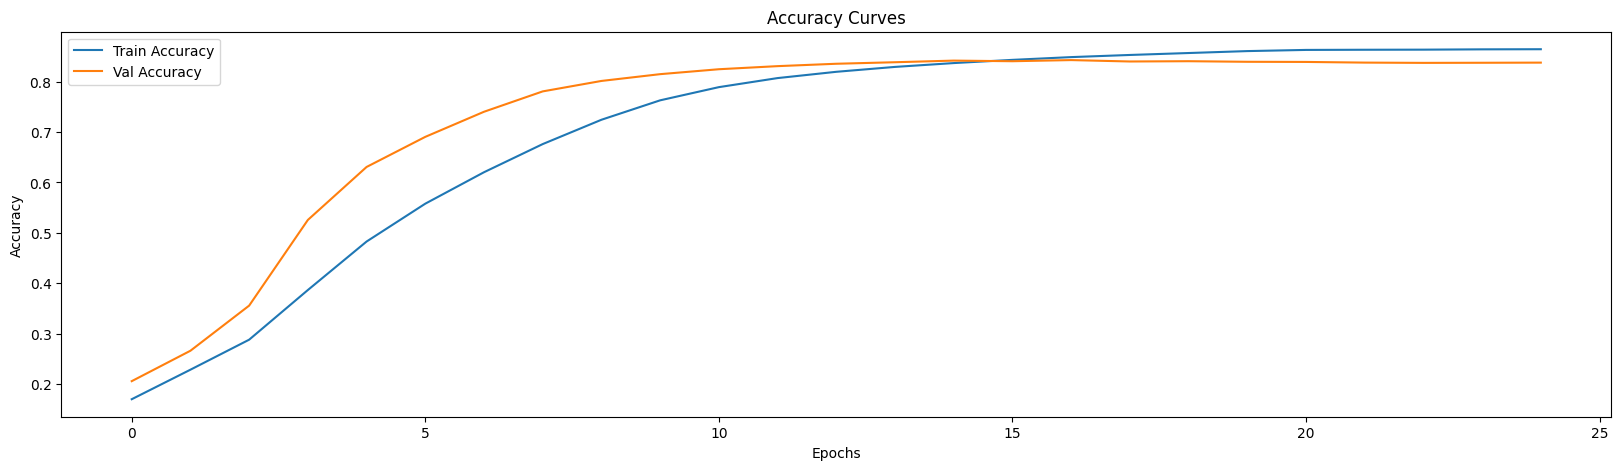

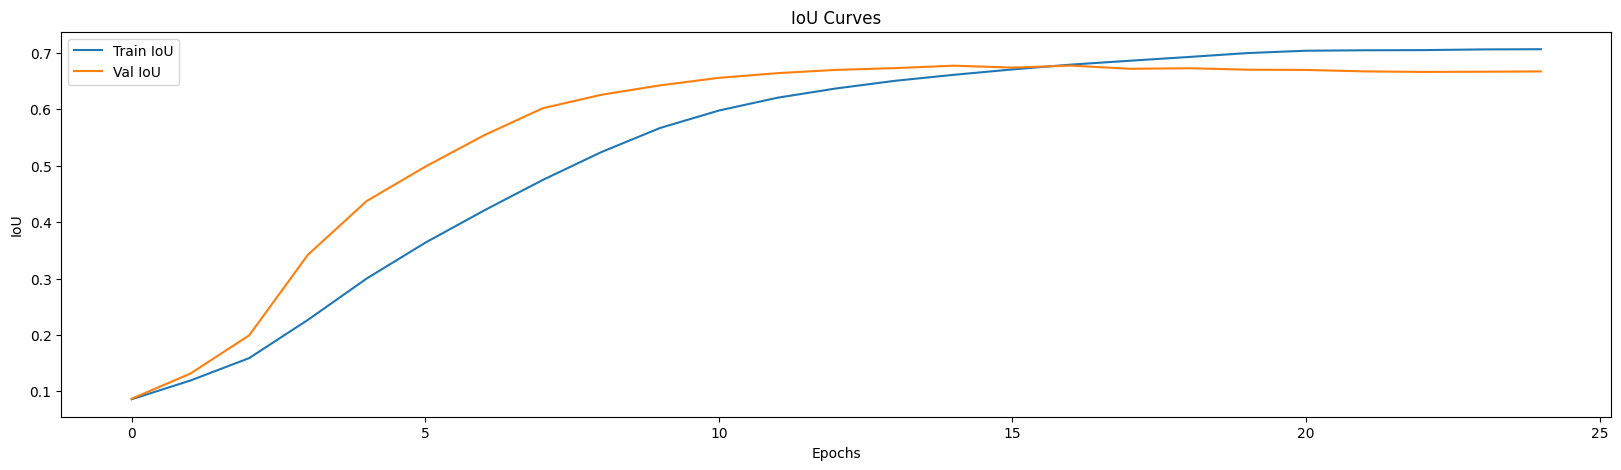

In [52]:
training_plots(history_augmented)

In [37]:
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

In [81]:
train_images, train_labels = tuple(zip(*train))
preds = unet_augmented.predict(train_batches)
print(classification_report(np.array(train_labels).flatten(), np.array(tf.argmax(preds, axis=-1)).flatten()))

7/7 [==============================] - 1s 109ms/step
              precision    recall  f1-score   support

           0       0.93      0.90      0.92  16916389
           1       0.62      0.80      0.70   5165033
           2       0.87      0.70      0.78   5443698

    accuracy                           0.84  27525120
   macro avg       0.81      0.80      0.80  27525120
weighted avg       0.86      0.84      0.85  27525120



In [ ]:
m = tf.keras.metrics.MeanIoU(num_classes=3)
m.update_state(train_labels, tf.argmax(preds, axis=-1))
m.result().numpy()

In [59]:
images, labels = tuple(zip(*val))
preds = unet_augmented.predict(val_batches)
pred_mask = tf.argmax(preds, axis=-1) 

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 115ms/step


In [45]:
print(classification_report(np.array(labels).flatten(), np.array(pred_mask).flatten()))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91   3642002
           1       0.71      0.71      0.71   1405225
           2       0.86      0.72      0.78   1506373

    accuracy                           0.84   6553600
   macro avg       0.82      0.79      0.80   6553600
weighted avg       0.84      0.84      0.84   6553600



In [60]:
m.reset_state()
m.update_state(labels, pred_mask)
augmented_iou = m.result().numpy()

In [48]:
#plot_validation_masks(images, preds, labels)

# Comparison

In [61]:
aug_metrics = classification_report(np.array(labels).flatten(), np.array(pred_mask).flatten(), output_dict=True)

In [65]:
aug = [aug_metrics["accuracy"],aug_metrics["macro avg"]["precision"], aug_metrics["macro avg"]["recall"], aug_metrics["macro avg"]["f1-score"], augmented_iou]
regular = [regular_metrics["accuracy"],regular_metrics["macro avg"]["precision"], regular_metrics["macro avg"]["recall"], regular_metrics["macro avg"]["f1-score"], regular_iou]
metrics = ["accuracy", "precision", "recall", "f1-score", "mean IoU"]

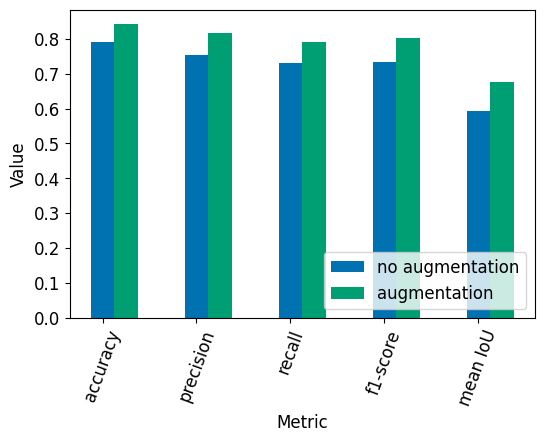

In [ ]:
# barplot with one bar for each
# acccuracy, precision, recall, f1, mean_iou
plt.style.use('seaborn-v0_8-colorblind') 
X_axis = np.arange(len(metrics))
num_bars = 2
width = 1/(num_bars+2)
i=1
plt.figure(figsize=(6,4))
plt.bar(X_axis+(width*1), regular, width, label="no augmentation")
plt.bar(X_axis+(width*2), aug, width, label="augmentation")
plt.xticks(X_axis+(width*np.ceil(num_bars/2)), metrics, rotation=70)
plt.tick_params(labelsize=12)
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.show()